# fine-tune on Bert with external data

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
# Load the training and testing datasets
train_essays = pd.read_csv("./llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("./llm-detect-ai-generated-text/test_essays.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


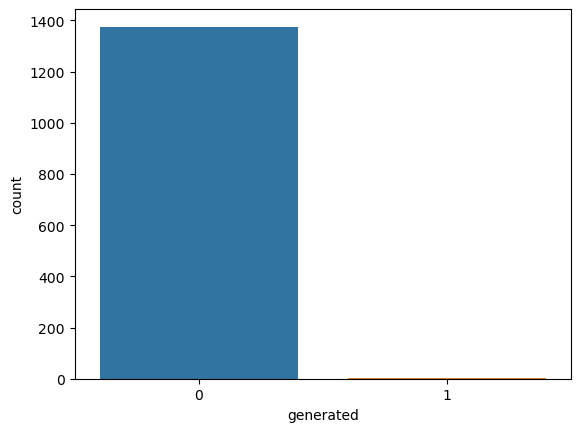

In [7]:
# Explore the training data
train_essays.info()

sns.countplot(data=train_essays, x='generated')
plt.show()

In [5]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


<class 'pandas.core.frame.DataFrame'>
Index: 32248 entries, 42917 to 4037
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       32248 non-null  object
 1   generated  32248 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 755.8+ KB


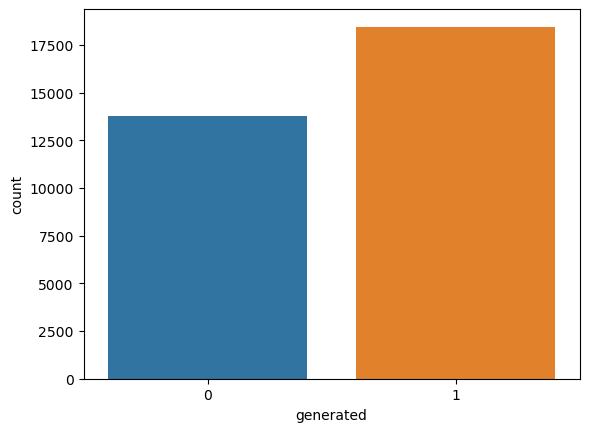

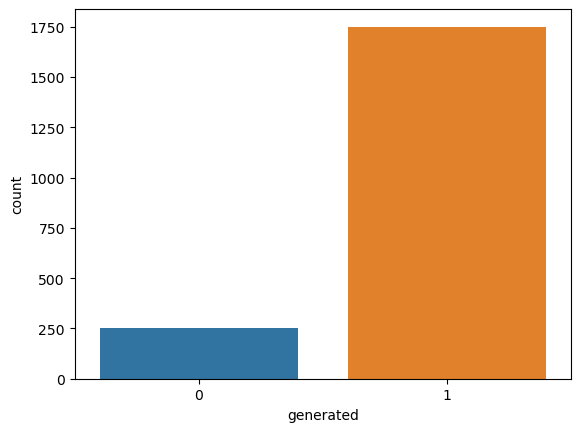

In [11]:
# Load the external dataset
exter_data1 = pd.read_csv('daigt-proper-train-dataset/train_drcat_04.csv')[['text','label','source']]
exter_data2 = pd.read_csv('argugpt/argugpt.csv')[['text']]
exter_data1.rename(columns={'label':'generated'}, inplace=True)
exter_data2['generated'] = 1

ext_df = pd.concat([
    exter_data1[exter_data1.source=='persuade_corpus'].sample(10000),
    exter_data1[exter_data1.source!='persuade_corpus'],
    exter_data2
])
ext_df = ext_df[['text', 'generated']]
ext_df.info()

# Check for class balance
sns.countplot(data=ext_df, x='generated')
plt.show()

# Pick 250 data with label 0 and 1750 data with label 1
ext_df = pd.concat([
    ext_df[ext_df.generated==0].sample(250),
    ext_df[ext_df.generated==1].sample(1750)
])

# Check for class balance
sns.countplot(data=ext_df, x='generated')
plt.show()


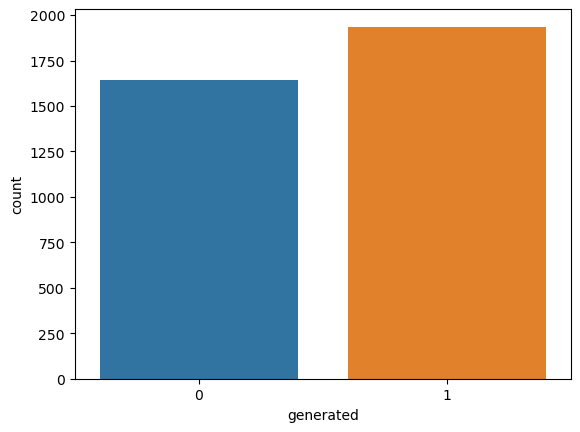

In [12]:
# Combine train_essays with external data
train_essays = pd.concat([train_essays, ext_df])

# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()


In [13]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)

In [14]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['generated'], test_size=0.3, random_state=42)


In [15]:
# Tokenization and Encoding for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)
tokenizer.save_pretrained('./tokenizer/bert-base-uncased')

('./tokenizer/bert-base-uncased/tokenizer_config.json',
 './tokenizer/bert-base-uncased/special_tokens_map.json',
 './tokenizer/bert-base-uncased/vocab.txt',
 './tokenizer/bert-base-uncased/added_tokens.json')

In [16]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')


In [17]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)


In [18]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)


In [19]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [20]:
# save the pretrained model to local so that I can use it without internet
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.save_pretrained('./models/bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('./models/bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 10

/Users/yuanlingzhi/anaconda3/envs/ml_zjb/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
losses = []
accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0

    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        preds = outputs.logits.argmax(dim=1)
        total_correct += torch.sum(preds == labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_loader.dataset)

    losses.append(avg_train_loss)
    accuracies.append(train_acc)    
    
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.legend()
plt.show()

  0%|          | 0/157 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [22]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


100%|██████████| 18/18 [01:16<00:00,  4.27s/it]


In [26]:
# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Save the model
torch.save(model.state_dict(), 'bert_model.pt')

Validation Accuracy: 1.00


In [25]:
# Test data processing
test_inputs = tokenizer(test_essays['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Move input tensor to the same device as the model
test_inputs = {key: value.to(device) for key, value in test_inputs.items()}

# Generate predictions using your trained model
with torch.no_grad():
    outputs = model(**test_inputs)
    logits = outputs.logits

# Assuming the first column of logits corresponds to the negative class (non-AI-generated) 
# and the second column corresponds to the positive class (AI-generated)
predictions = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Move predictions back to CPU

# Create a submission DataFrame with essay IDs and corresponding predictions
submission = pd.DataFrame({
    'id': test_essays['id'],
    'generated': predictions
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)
